In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
import rt_analysis as rt
import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [2]:
itp_id = 4 ## AC Transit

In [3]:
import numpy as np

In [4]:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

In [5]:
date_range

array(['2022-04-30', '2022-05-01', '2022-05-02', '2022-05-03',
       '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-07',
       '2022-05-08'], dtype='datetime64[D]')

# Generate analysis data for all dates

In [6]:
pbar = tqdm()

0it [00:00, ?it/s]

In [7]:
# for date in date_range:
#     date = date.astype(dt.date)
#     try:
#         rt_analysis = rt.OperatorDayAnalysis(itp_id, date, pbar)
#         rt_analysis.export_views_gcs()
#         print(f'complete for date: {date}')
#     except:
#         print(f'failed for date: {date}')
#         continue

In [8]:
# for date in date_range:
#     date = date.astype(dt.date)
#     try:
#         rt_day = rt_filter_map_plot.from_gcs(itp_id, date)
#         print(f'complete for date: {date}')
#     except:
#         print(f'failed for date: {date}')
#         continue

In [9]:
rt_day = rt_filter_map_plot.from_gcs(4, dt.date(2022, 5, 1))

found parquet


In [12]:
rt_day.stop_delay_view.dropna(subset=['stop_id']) >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds
0,574.272090,1346,Walnut Av & Guardino Dr,POINT (-173895.624 -49034.139),shp-217-10,-5.354689e+18,13428010,2.0,2022-05-01 15:31:28,217,217,0,2022-05-01 15:32:21.890113,53.0
1,943.266663,1341,Walnut Av & Gallaudet Dr,POINT (-173601.966 -48812.414),shp-217-10,-5.354689e+18,13428010,3.0,2022-05-01 15:32:14,217,217,0,2022-05-01 15:33:11.180694,57.0
2,1204.489885,1394,Walnut Av & Walnut Circle,POINT (-173406.632 -48740.636),shp-217-10,-5.354689e+18,13428010,4.0,2022-05-01 15:32:51,217,217,0,2022-05-01 15:33:53.019003,62.0


In [13]:
corridor = gpd.read_file('./CMCP_StudyAreaBoundary.geojson').to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [14]:
to_clip = rt_day.stop_delay_view.drop_duplicates(subset=['shape_id', 'stop_sequence']).dropna(subset=['stop_id'])

In [15]:
clipped = to_clip.clip(corridor)

In [16]:
shape_seqences = (rt_day.stop_delay_view.dropna(subset=['stop_id']) >> distinct(_.shape_id, _.stop_sequence) >> arrange(_.shape_id, _.stop_sequence))

In [52]:
stops_per_shape = shape_seqences >> group_by(_.shape_id) >> summarize(n_stops = _.shape_id.size)

# can use this as # of stops in corr...
stops_in_corr = clipped >> group_by(_.shape_id) >> summarize(in_corr = _.shape_id.size)
stop_comparison = stops_per_shape >> inner_join(_, stops_in_corr, on='shape_id')

In [55]:
stop_comparison = stop_comparison >> mutate(corr_shape = _.in_corr > _.n_stops / 2)

In [56]:
corr_shapes = stop_comparison >> filter(_.corr_shape)

In [63]:
shape_sequence_filter = {}
for shape_id in corr_shapes.shape_id.unique():
# for shape_id in ['shp-10-09']:
    shape_sequence_filter[shape_id] = {}
    clipped_min = (clipped >> filter(_.shape_id == shape_id)).stop_sequence.min()
    clipped_max = (clipped >> filter(_.shape_id == shape_id)).stop_sequence.max()
    this_shape = shape_seqences >> filter(_.shape_id == shape_id)
    filter_min = (this_shape >> filter(_.stop_sequence < clipped_min)).stop_sequence.max()
    filter_max = (this_shape >> filter(_.stop_sequence > clipped_max)).stop_sequence.min()
    shape_sequence_filter[shape_id]['min'] = max(0, filter_min)
    shape_sequence_filter[shape_id]['max'] = filter_max if not np.isnan(filter_max) else clipped_max

In [64]:
shape_sequence_filter

{'shp-10-09': {'min': 0, 'max': 33.0},
 'shp-10-10': {'min': 0, 'max': 35.0},
 'shp-1T-05': {'min': 0, 'max': 32.0},
 'shp-1T-51': {'min': 2.0, 'max': 33.0},
 'shp-40-18': {'min': 0, 'max': 67.0},
 'shp-40-19': {'min': 8.0, 'max': 34.0},
 'shp-40-63': {'min': 2.0, 'max': 73.0},
 'shp-40-64': {'min': 2.0, 'max': 30.0},
 'shp-41-54': {'min': 0, 'max': 26.0},
 'shp-45-04': {'min': 12.0, 'max': 52.0},
 'shp-45-53': {'min': 4.0, 'max': 43.0},
 'shp-73-01': {'min': 6.0, 'max': 19.0},
 'shp-73-51': {'min': 4.0, 'max': 17.0},
 'shp-801-01': {'min': 36.0, 'max': 84.0},
 'shp-90-02': {'min': 0, 'max': 14.0},
 'shp-90-54': {'min': 11.0, 'max': 22.0}}

In [65]:
# gdf = rt_day.stop_delay_view >> filter(_.shape_id == 'shp-40-19', _.stop_sequence >= 8, _.stop_sequence <= 34)
# gdf = gdf[['stop_id', 'geometry']]

# pd.concat([corridor, gdf]).explore(tiles = "CartoDB positron")

# Algorithm

* Clip stops to corridor
* Get first and last stops in corridor for each shape_id, then find 1 stop before and 1 stop after for each
* Filter stop_delay_view based on those stops
* Assert that more than 50% of filtered stops within corridor, if not then drop shape (remove shapes starting/ending in corridor but mostly running outside)

In [75]:
fn = lambda x: x.shape_id in (shape_sequence_filter.keys()) and x.stop_sequence >= shape_sequence_filter[x.shape_id]['min'] and x.stop_sequence <= shape_sequence_filter[x.shape_id]['max']
rt_day.stop_delay_view['corridor'] = rt_day.stop_delay_view.apply(fn, axis=1)

In [76]:
mappable_stops = (rt_day.stop_delay_view
                  >> distinct(_.shape_id, _.stop_sequence, _keep_all=True)
                  >> filter(_.corridor)
                  >> select(_.stop_id, _.geometry, _.stop_sequence)
                 )

In [77]:
pd.concat([mappable_stops, corridor]).explore(tiles = "CartoDB positron")

In [78]:
corridor_filtered = rt_day.stop_delay_view >> filter(_.corridor)

In [79]:
corridor_filtered >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds,corridor
0,5705.646177,6142,73rd Avenue,POINT (-192528.110 -26288.234),shp-1T-05,9.215752e+18,5811010,13.0,2022-05-01 16:27:55,1T,1T,1,2022-05-01 16:29:36.270593,101.0,True
1,2171.517440,6126,Durant Avenue,POINT (-190436.749 -29025.856),shp-1T-05,9.215752e+18,5811010,5.0,2022-05-01 16:17:24,1T,1T,1,2022-05-01 16:18:36.929148,72.0,True
2,9302.157774,6181,Fruitvale,POINT (-195568.203 -24367.612),shp-1T-05,9.215752e+18,5811010,21.0,2022-05-01 16:40:00,1T,1T,1,2022-05-01 16:43:08.137738,188.0,True


In [81]:
first_stops = corridor_filtered >> group_by(_.trip_id) >> summarize(stop_sequence = _.stop_sequence.min())

In [87]:
entry_delays = (first_stops
                >> inner_join(_, corridor_filtered, on = ['trip_id', 'stop_sequence'])
                >> select(_.trip_id, _.delay_seconds)
                >> rename(entry_delay_seconds = _.delay_seconds)
               )

In [96]:
entry_delays >> head(3)

,trip_id,entry_delay_seconds
0,10010010,0.0
1,10024010,0.0
2,10032010,122.0


In [93]:
with_entry_delay = corridor_filtered >> inner_join(_, entry_delays, on='trip_id')
with_entry_delay = with_entry_delay >> mutate(corridor_delay_seconds = _.delay_seconds - _.entry_delay_seconds)
with_entry_delay >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds,corridor,entry_delay_seconds,corridor_delay_seconds
0,5705.646177,6142,73rd Avenue,POINT (-192528.110 -26288.234),shp-1T-05,9.215752e+18,5811010,13.0,2022-05-01 16:27:55,1T,1T,1,2022-05-01 16:29:36.270593,101.0,True,123.0,-22.0
1,2171.517440,6126,Durant Avenue,POINT (-190436.749 -29025.856),shp-1T-05,9.215752e+18,5811010,5.0,2022-05-01 16:17:24,1T,1T,1,2022-05-01 16:18:36.929148,72.0,True,123.0,-51.0
2,9302.157774,6181,Fruitvale,POINT (-195568.203 -24367.612),shp-1T-05,9.215752e+18,5811010,21.0,2022-05-01 16:40:00,1T,1T,1,2022-05-01 16:43:08.137738,188.0,True,123.0,65.0


array([[<AxesSubplot:title={'center':'corridor_delay_seconds'}>]],
      dtype=object)

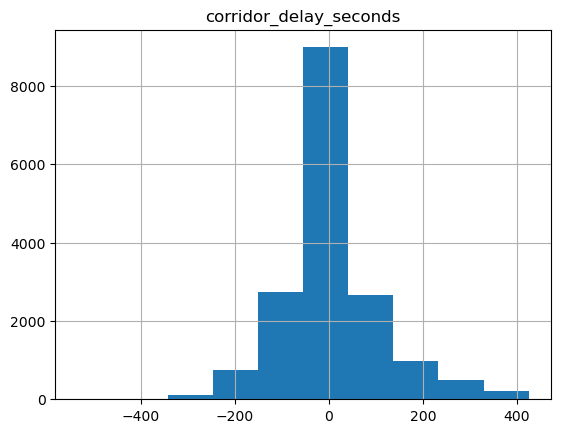

In [101]:
(with_entry_delay >> filter(_.corridor_delay_seconds < _.corridor_delay_seconds.quantile(.99))).hist(column='corridor_delay_seconds')

In [94]:
with_entry_delay >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())

,median_corridor_delay_seconds
0,0.0


In [95]:
with_entry_delay >> group_by(_.trip_id) >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())

,trip_id,median_corridor_delay_seconds
0,10010010,0.0
1,10024010,0.0
2,10032010,43.0
3,1004010,3.5
4,10076010,-18.0
...,...,...
585,9804010,-47.5
586,983010,108.0
587,9860010,0.0
588,9883010,-9.0


array([[<AxesSubplot:title={'center':'median_corridor_delay_seconds'}>]],
      dtype=object)

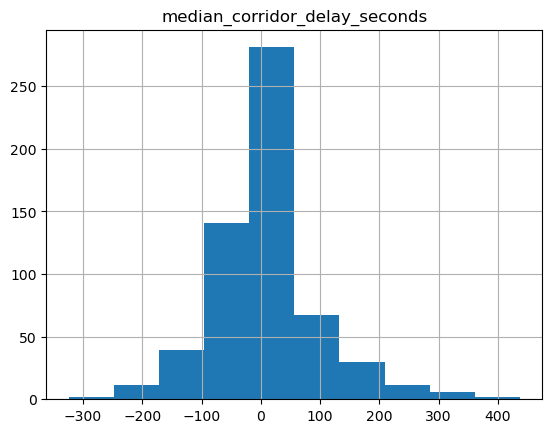

In [103]:
(with_entry_delay >> group_by(_.trip_id) >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())).hist(column='median_corridor_delay_seconds')

In [97]:
(with_entry_delay
 >> group_by(_.trip_id)
 >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())
 >> summarize(sum_of_medians = _.median_corridor_delay_seconds.sum())
)

,sum_of_medians
0,3827.5
